In [1]:
import os
import mlflow
from scipy.special import softmax
import sys
import s3fs
from typing import List, Optional, Dict
import pytorch_lightning as pl
import torch
from torch import nn
from torch.optim import Adam, SGD
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mlflow
import pyarrow.parquet as pq
from models.model import FastTextModule, FastTextModel
from config.dataset import FastTextModelDataset
from tokenizer.tokenizer import NGramTokenizer
from config.preprocess import clean_text_feature
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from pytorch_lightning.trainer import Trainer

import explainability.utils
from explainability.explainability_viz import visualize_word_scores
# Automatic discovery : if MLFlow has been launched before Jupyter/VSCode
if "MLFLOW_TRACKING_URI" in os.environ:
    print(os.environ["MLFLOW_TRACKING_URI"])
else:
    print("MLflow was not automatically discovered, a tracking URI must be provided manually.")

%load_ext autoreload
%autoreload 2

https://user-meilametayebjee-mlflow.user.lab.sspcloud.fr


In [2]:
model_name = "fasttext-pytorch"
version = 6
module = mlflow.pytorch.load_model(model_uri=f"models:/{model_name}/{version}")
model = module.model

[['4332A']
 ['6630Z']
 ['6820B']
 ['7022Z']
 ['6820B']
 ['8559B']]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


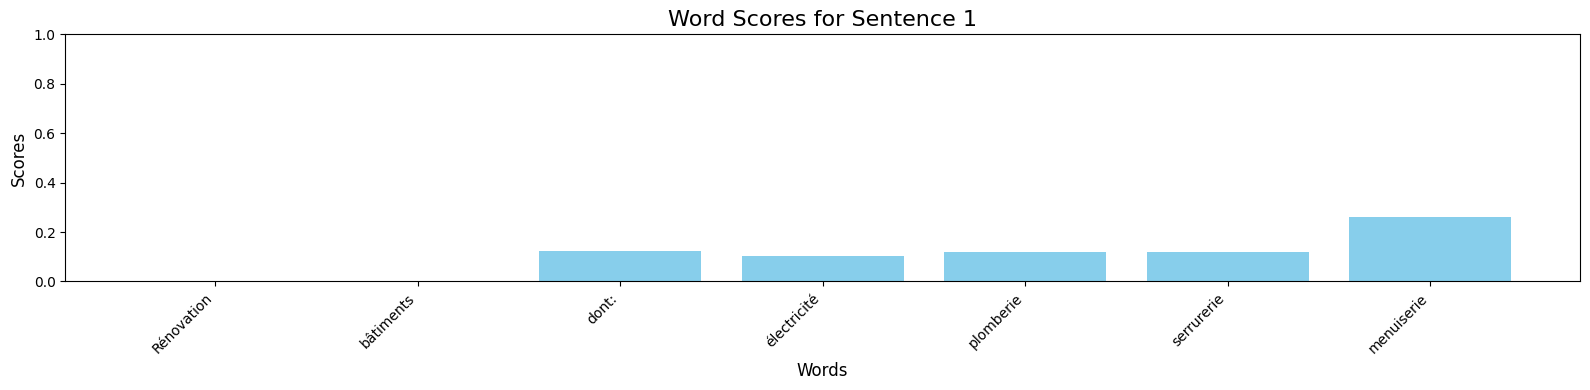

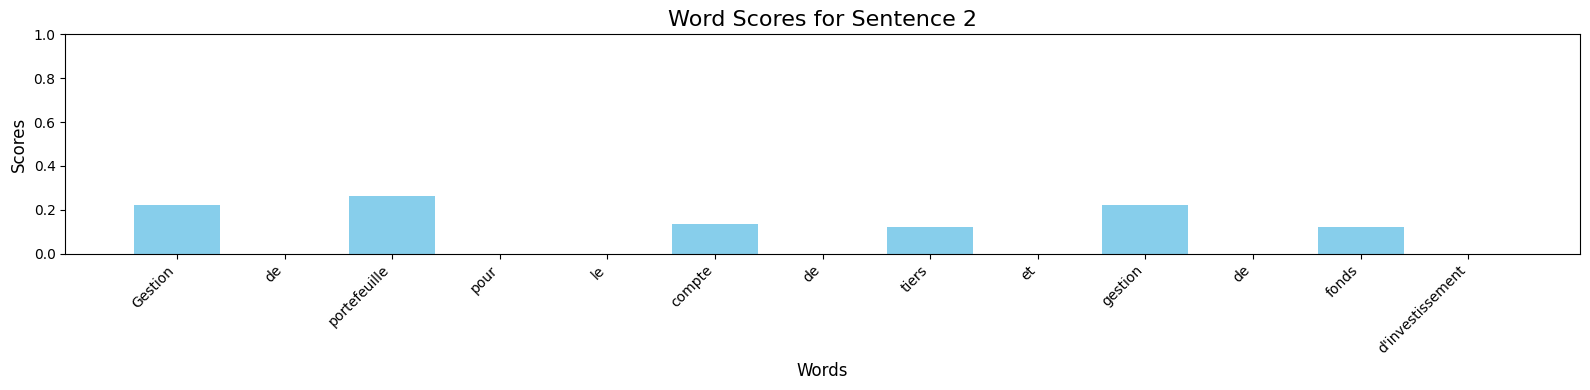

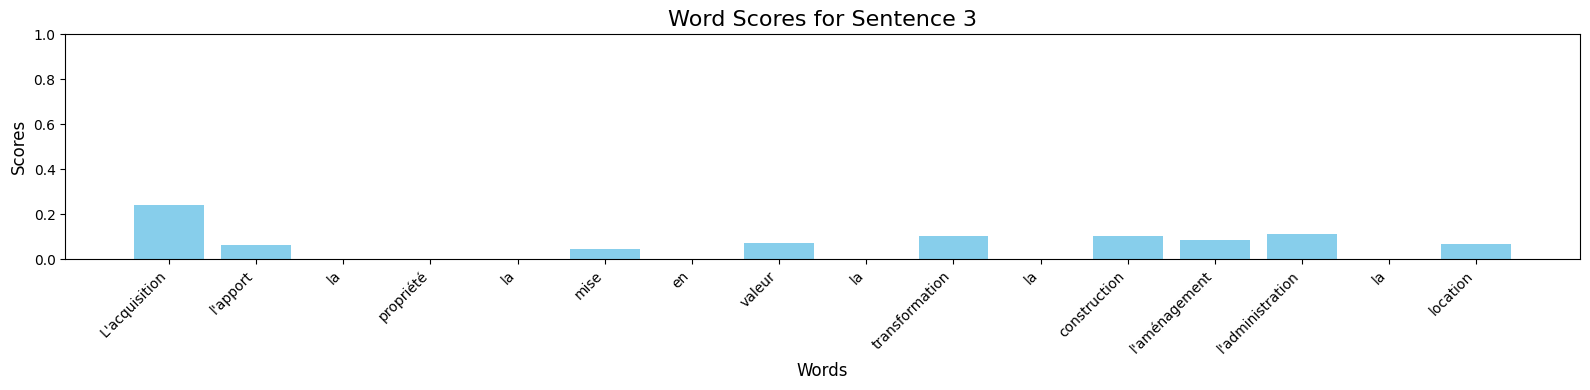

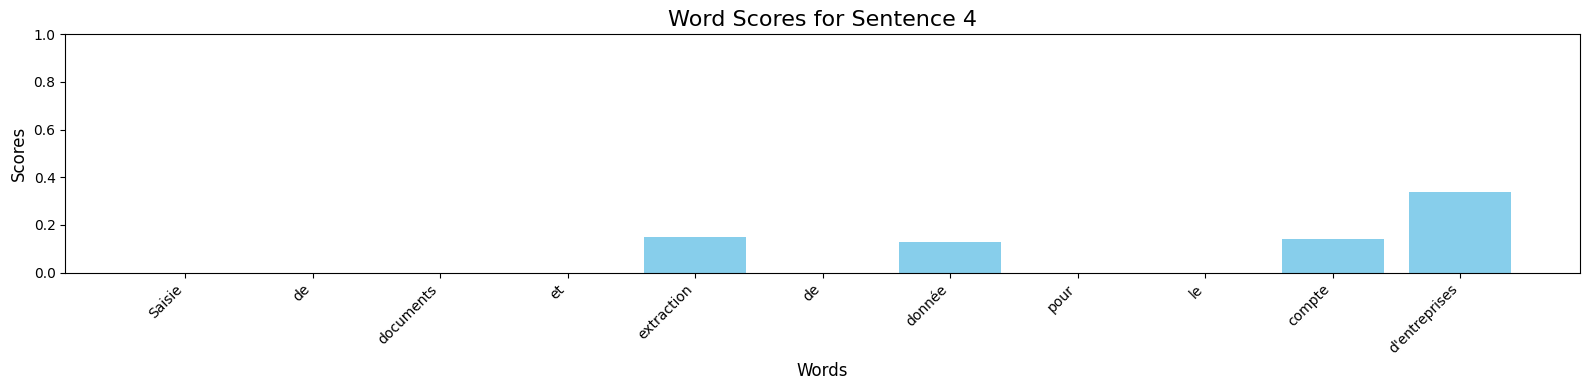

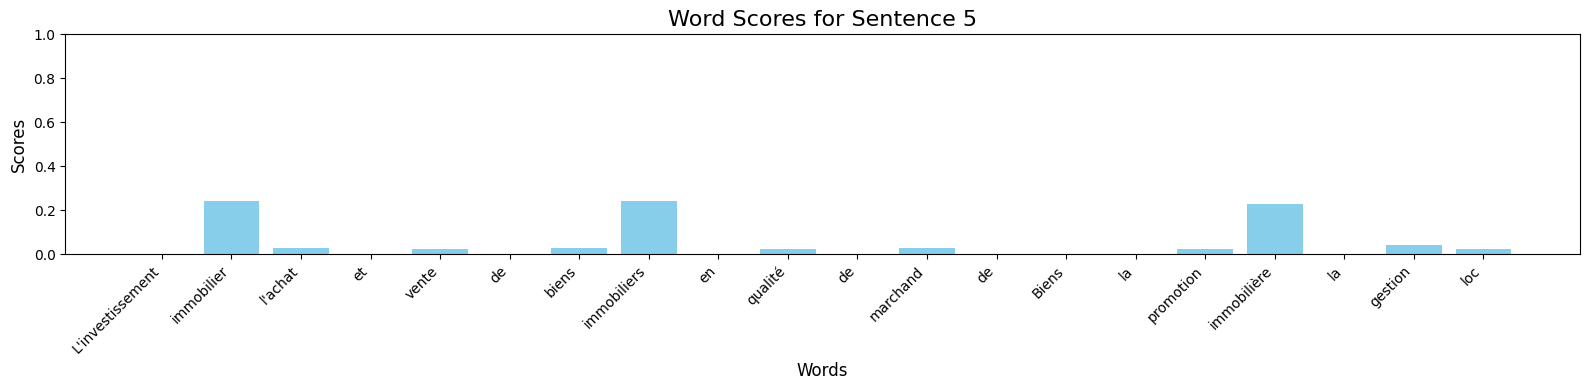

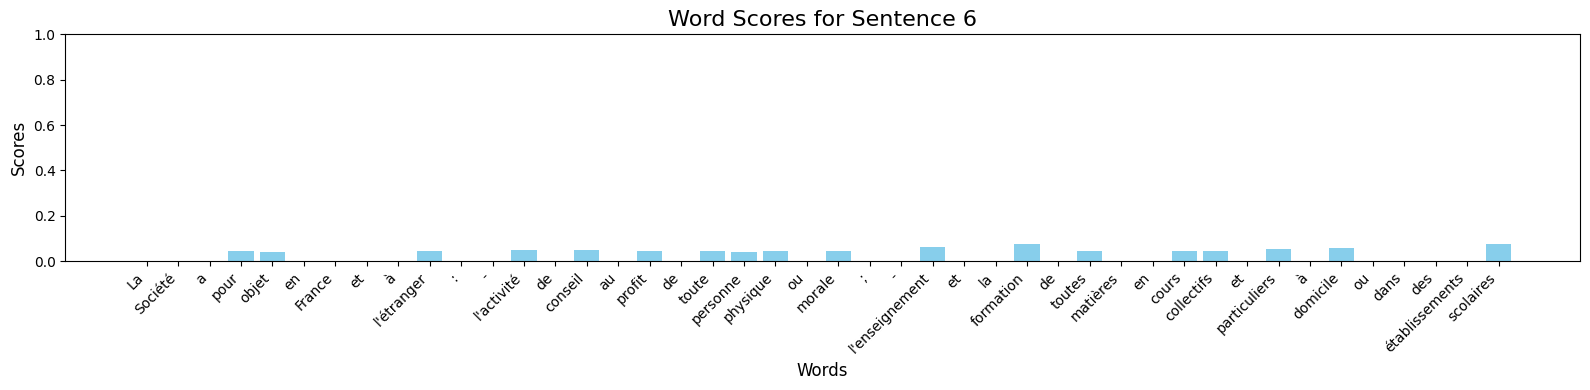

In [5]:
text = ["Rénovation bâtiments dont: électricité, plomberie, serrurerie, menuiserie", "Gestion de portefeuille pour le compte de tiers et gestion de fonds d'investissement",
"L'acquisition, l'apport, la propriété, la mise en valeur, la transformation, la construction, l'aménagement, l'administration, la location", 
"Saisie de documents et extraction de donnée pour le compte d'entreprises", "L'investissement immobilier, l'achat et vente de biens immobiliers en qualité de marchand de Biens, la promotion immobilière, la gestion loc",
"La Société a pour objet en France et à l'étranger : - l'activité de conseil au profit de toute personne physique ou morale ; - l'enseignement et la formation de toutes matières en cours collectifs et particuliers à domicile ou dans des établissements scolaires"]

#text = ["coiffure, cheveux,  salon de "]
params = {'additional_var':[1]*len(text)} 
pred, confidence, all_scores = model.predict_and_explain(text, params)
print(pred)
print(confidence)
explainability.explainability_viz.visualize_word_scores(all_scores, text)